# Introduction

This notebook is my playground to test out some concepts I found reading  [**Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow**: Concepts, Tools, and Techniques to Build Intelligent Systems 2nd Edition](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/).  
I would highly recommend this book to everyone, regardless of your expertise level, especially if Tensorflow is your thing.

In this notebook I'll show how to use Sequential and Functional Keras API, also to discover best parameters using GridSearchCV or RandomizedSearchCV.

# Table of Contents:

- **1. [Dataset Description](#description)**
- **2. [Pre-processing](#pre-processing)**
  - **2.1. [Feature engineering](#feat-eng)**
  - **2.2. [Fill in missing data](#feat-fill)**
  - **2.3. [Encode Categorical & Scale continuous variables](#feat-encode)**
- **3. [Build, Train and Evaluate the Model](#network)**
  - **3.1. [Tensorflow2.0 & Keras](#tensorflow)**
  - **3.2. [Keras building blocks](#layers)**
  - **3.3. [Build a simple model - 0.76555 score](#simple-model)**
    - **3.3.1. [Model architecture](#architecture)**
    - **3.3.2. [Compile the Model](#compile)**
    - **3.3.3. [Train the Model](#train)**
    - **3.3.4. [Predict on the Test data and submit to Kaggle](#predict)**  
  - **3.4. [Keras Model using Functional API - 0.77511 score](#functional-model)**
  - **3.5. [Hyperparameter Tuning](#hyperparameter)**


<a id="description"></a>
## Dataset description

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others. The challenge is to find the likehood to survive, finding relevant patterns in the data. This is one of the most used dataset in data science, along with MNIST and Housing Prices.
The dataset contain folllowing information about each person embarked on Titanic:

Variable | Definition |Key
--- | --- | ---
survival | Survival | 0 = No, 1 = Yes
pclass | Ticket class |1 = 1st, 2 = 2nd, 3 = 3rd
sex | Sex	
Age | Age in years	
sibsp | # of siblings / spouses aboard the Titanic	
parch | # of parents / children aboard the Titanic	
ticket |Ticket number	
fare | Passenger fare	
cabin | Cabin number	
embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton

The data has been split into two groups:

* training set (train.csv) -- should be used to build your machine learning models and it has the labels
* test set (test.csv) -- should be used to see how well your model performs on unseen data, as I'm using Kaggle the ground truth for each passenger is not provided

Although **EDA** is very important to visualize and understand the data, I'm going to skip that part and focus on the model itself. But if you are interested in exploring the data then there are a bunch of useful [notebooks published for Titanic dataset](https://www.kaggle.com/c/titanic/notebooks). 

In [1]:
## Import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
tf.__version__

'2.1.0'

In [2]:
# Load dataset
train = pd.read_csv("../input/titanic/train.csv")
test = pd.read_csv("../input/titanic/test.csv")

# Adding a column in each dataset before merging
train['Type'] = 'train'
test['Type'] = 'test'

# Merging train and test
data = train.append(test, sort=False)

<a id="pre-processing"></a>
## 2. Pre-Processing the data
Pre-processing refers to the transformations applied to our data before feeding it to the algorithm. Data Preprocessing is a technique that is used to convert the raw data into a clean data set.  
Deep Learning cannot operate on label data directly. It requires all input variables and output variables to be numeric, threfore the categorical data will be transformed in numbers and numerical values will be scaled for better convergence.
We'll introduce new features as well, that helps the deep learning algorithms to find better patterns, which will increase prediction accuracy.

In [3]:
# explore the initial data, first 5 rows of the dataset
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Type
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train


<a id="feat-eng"></a>
### 2.1. Feature Engineering 

Feature engineering is the process of using domain knowledge to extract features from raw data via data mining techniques. These features can be used to improve the performance of machine learning algorithms.  
Based on initial exploration of the data, we observed that the Titles from the names (like Miss, Mrs etc) could influence the performance of the model. Therefore we extract those and populate within a new column. Also we consolidate **Parch** and **SibSp** within a single column, named **Family_Size**.

In [4]:
# Cleaning name and extracting Title
for name_string in data['Name']:
    data['Title'] = data['Name'].str.extract('([A-Za-z]+)\.', expand=True)
    
# Replacing rare titles 
mapping = {'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs', 'Major': 'Other', 
           'Col': 'Other', 'Dr' : 'Other', 'Rev' : 'Other', 'Capt': 'Other', 
           'Jonkheer': 'Royal', 'Sir': 'Royal', 'Lady': 'Royal', 
           'Don': 'Royal', 'Countess': 'Royal', 'Dona': 'Royal'}
           
data.replace({'Title': mapping}, inplace=True)

In [5]:
data['Family_Size'] = (data['Parch'] + data['SibSp']).astype(int)

<a id="feat-fill"></a>
### 2.2. Fill in the missing data

Although it is possible to train algorithms with missing values, it's highly recommended to clean the data.  
**Some Strategies**:
* Drop the missing values: Drop the row if a particular feature is missing
* Replace the missing values with mean/median imputation:  Calculate the mean or median of the feature and replace it with the missing values. This is an approximation which can add variance to the data set. But the loss of the data can be negated by this method which yields better results compared to removal of rows and columns

In our example **Cabin** will be dropped off as has no importance, **Age** will be filled with the mean for the corresponding category
and for  **Embarked** the two missing fields will be added manually.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 15 columns):
PassengerId    1309 non-null int64
Survived       891 non-null float64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Type           1309 non-null object
Title          1309 non-null object
Family_Size    1309 non-null int64
dtypes: float64(3), int64(5), object(7)
memory usage: 163.6+ KB


In [7]:
data.groupby(["Sex", "Pclass"]).Age.mean()

Sex     Pclass
female  1         37.037594
        2         27.499223
        3         22.185329
male    1         41.029272
        2         30.815380
        3         25.962264
Name: Age, dtype: float64

In [8]:
data['Age'].fillna(data.groupby(["Sex", "Pclass"])['Age'].transform("mean"), inplace=True)

In [9]:
data.loc[pd.isnull(data['Embarked'])]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Type,Title,Family_Size
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,train,Miss,0
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,train,Mrs,0


In [10]:
data.loc[61,'Embarked'] = 'S'
data.loc[829,'Embarked'] = 'S'

In [11]:
data['Fare'].fillna(data['Fare'].mean(), inplace = True)

<a id="feat-encode"></a>
### 2.3. Encode Categorical and Scale Continuous variables

There are two types of data:
* Categorical : Features whose values are taken from a defined set of values. For instance, days in a week : {Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday} is a category because its value is always taken from this set. Another example could be the Boolean set : {True, False}
* Numerical : Features whose values are continuous or integer-valued. They are represented by numbers and possess most of the properties of numbers. For instance, number of steps you walk in a day, or the speed at which you are driving your car at.

#### The transformation:

**Encode Categorical Variables**  
We need to convert all categorical variables into numeric format. The categorical variables we will be keeping are Embarked, Sex and Title.

**Scale Continuous variables**  
Standardization is a useful technique to transform attributes with a Gaussian distribution and differing means and standard deviations to a standard Gaussian distribution with a mean of 0 and a standard deviation of 1.  
We can standardize data using scikit-learn with the StandardScaler class.



In [12]:
# First drop the variables we won't be using in the model
data.drop(['Cabin', 'Name', 'Ticket', 'PassengerId', 'SibSp', 'Parch'], axis=1, inplace=True)

In [13]:
# convert to cateogry dtype
data['Sex'] = data['Sex'].astype('category')
# convert to category codes
data['Sex'] = data['Sex'].cat.codes

In [14]:
# subset all categorical variables which need to be encoded
categorical = ['Embarked', 'Title', 'Pclass']

for cat in categorical:
    data = pd.concat([data, 
                    pd.get_dummies(data[cat], prefix=cat)], axis=1)
    del data[cat]

In [15]:
# scale numerical values
continuous = ['Age', 'Fare', 'Family_Size']

scaler = StandardScaler()

for val in continuous:
    data[val] = data[val].astype('float64')
    data[val] = scaler.fit_transform(data[val].values.reshape(-1, 1))

In [16]:
# checkout the data after all transoformations
data.head()

,Survived,Sex,Age,Fare,Type,Family_Size,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Title_Royal,Pclass_1,Pclass_2,Pclass_3
0,0.0,1,-0.560331,-0.503595,train,0.073352,0,0,1,0,0,1,0,0,0,0,0,1
1,1.0,0,0.655107,0.734503,train,0.073352,1,0,0,0,0,0,1,0,0,1,0,0
2,1.0,0,-0.256471,-0.490544,train,-0.558346,0,0,1,0,1,0,0,0,0,0,0,1
3,1.0,0,0.427212,0.382925,train,0.073352,0,0,1,0,0,0,1,0,0,1,0,0
4,0.0,1,0.427212,-0.488127,train,-0.558346,0,0,1,0,0,1,0,0,0,0,0,1


In [17]:
#Generate descriptive statistics. Descriptive statistics include those that summarize the central tendency, 
#dispersion and shape of a dataset’s distribution
data.describe()

,Survived,Sex,Age,Fare,Family_Size,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Title_Royal,Pclass_1,Pclass_2,Pclass_3
count,891.000000,1309.000000,1.309000e+03,1.309000e+03,1.309000e+03,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,0.383838,0.644003,2.459623e-16,1.602996e-17,2.593630e-16,0.206264,0.093965,0.699771,0.046600,0.201681,0.578304,0.151261,0.017571,0.004584,0.246753,0.211612,0.541635
std,0.486592,0.478997,1.000382e+00,1.000382e+00,1.000382e+00,0.404777,0.291891,0.458533,0.210862,0.401408,0.494019,0.358440,0.131435,0.067573,0.431287,0.408607,0.498454
min,0.000000,0.000000,-2.218643e+00,-6.437751e-01,-5.583461e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,-5.603308e-01,-4.911082e-01,-5.583461e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,-2.564715e-01,-3.643001e-01,-5.583461e-01,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,1.000000,5.791418e-01,-3.906640e-02,7.335229e-02,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,3.845630e+00,9.262219e+00,5.758637e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
# Cutting train and test
train = data[data['Type'] == 'train'].drop(columns = ['Type', 'Survived'])
train_ = data[data['Type'] == 'train']['Survived']

test = data[data['Type'] == 'test'].drop(columns = ['Type', 'Survived'])

X_train = train.values
y_train = train_.values

X_test = test.values
X_test = X_test.astype(np.float64, copy=False)

In [19]:
train.shape

(891, 16)

<a id="network"></a>
## 3. Create the Model.

<a id="tensorflow"></a>
### 3.1. TensorFlow 2.0 & Keras

TensorFlow is a free and open-source software library for dataflow and differentiable programming across a range of tasks and it is used for machine learning applications such as neural networks. Tensorflow has grown to become one of the most loved and widely adopted ML platforms in the world. TensorFlow offers multiple levels of abstraction so you can choose the right one for your needs. Build and train models by using the high-level Keras API, which makes getting started with TensorFlow and machine learning easy.  

Most notable additions in TensorFlow 2.0:
* tf.keras  - default TensorFlow's high-level API for building and training deep learning models.
* Eager execution -  is an imperative programming environment that evaluates operations immediately, without building graphs: operations return concrete values instead of constructing a computational graph to run later.
* Distribution Strategy API -  makes it easy to distribute and train models on different hardware configurations without changing the model definition.
* Standardized SavedModel file format - allows you to run your models with TensorFlow, deploy them with TensorFlow Serving, use them on mobile and embedded systems with TensorFlow Lite, and train and run in the browser or Node.js with TensorFlow.js.

Keras is a user-friendly API standard for machine learning and it is the central high-level API used to build and train models in TensorFlow 2.0. Importantly, Keras provides several model-building APIs (Sequential, Functional, and Subclassing), so you can choose the right level of abstraction for your project. 

The new architecture of TensorFlow 2.0 using a simplified, conceptual diagram:

![Tensorflow Architecture](https://1.bp.blogspot.com/-4C_bx62kOI4/XfE3XQT422I/AAAAAAAABmY/AbMfOO8yzjctmg30IcgOBaU5UmcZNpAtwCLcBGAsYHQ/s1600/model.png)


<a id="layers"></a>
### 3.2. Keras building blocks
Keras models are made by connecting configurable building blocks together.  
In Keras, you assemble layers to build models. A model is a graph of layers. The most common type of model is a stack of layers: the tf.keras.Sequential model.

<a id="simple-model"></a>
### 3.3. Build a simple model - 0.76555 score

<a id="architecture"></a>
#### 3.3.1. Model architecture

Sequential model is the simplest kind of Keras model for neural networks that are just composed of a single stack of layers connected sequentially.

Keras Dense Layer implements the operation: **output = activation(dot(input, kernel) + bias)** where **activation** is the element-wise activation function passed as the activation argument, **kernel** is a weights matrix created by the layer, and **bias** is a bias vector created by the layer.  
A neural network without an activation function is essentially just a linear regression model. The **activation function** does the non-linear transformation to the input making it capable to learn and perform more complex tasks. Most known activation functions are: **Sigmoid** , **Tanh** and **Relu**.

In [20]:
# Simple model
model1 = keras.models.Sequential()
model1.add(keras.layers.Dense(18, input_dim = X_train.shape[1], activation = keras.activations.relu))
model1.add(keras.layers.Dense(8, activation = keras.activations.relu))
model1.add(keras.layers.Dense(1, activation = keras.activations.sigmoid))

In [21]:
# visualize the model
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 18)                306       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 152       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 467
Trainable params: 467
Non-trainable params: 0
_________________________________________________________________


In [22]:
# further explore the model
weights, biases = model1.layers[1].get_weights()
weights.shape

(18, 8)

<a id="compile"></a>
#### 3.3.2. Compile the model

tf.keras.Model.compile takes three important arguments:

* optimizer: This object specifies the training procedure. Pass it optimizer instances from the tf.keras.optimizers module, such as tf.keras.optimizers.Adam or tf.keras.optimizers.SGD. If you just want to use the default parameters, you can also specify optimizers via strings, such as 'adam' or 'sgd'.
* loss: The function to minimize during optimization. Common choices include mean square error (mse), categorical_crossentropy, and binary_crossentropy. Loss functions are specified by name or by passing a callable object from the tf.keras.losses module.
* metrics: Used to monitor training. These are string names or callables from the tf.keras.metrics module.
* Additionally, to make sure the model trains and evaluates eagerly, you can make sure to pass run_eagerly=True as a parameter to compile.

In [23]:
# Compiling our model
model1.compile(optimizer = keras.optimizers.SGD(), 
               loss = keras.losses.binary_crossentropy, 
               metrics = [tf.keras.metrics.binary_accuracy])


This is equivalent to:

model1.compile(loss="binary_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

<a id="train"></a>
#### 3.3.3. Train the model

tf.keras.Model.fit takes three important arguments:

* epochs: Training is structured into epochs. An epoch is one iteration over the entire input data (this is done in smaller batches).
* batch_size: When passed NumPy data, the model slices the data into smaller batches and iterates over these batches during training. This integer specifies the size of each batch. Be aware that the last batch may be smaller if the total number of samples is not divisible by the batch size.
* validation_data: When prototyping a model, you want to easily monitor its performance on some validation data. Passing this argument—a tuple of inputs and labels—allows the model to display the loss and metrics in inference mode for the passed data, at the end of each epoch.
* validation_split: Float between 0 and 1. Same as validation_data, but the  but it use a fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch.

In [24]:
history = model1.fit(X_train, y_train, epochs=100, validation_split=0.2)

Train on 712 samples, validate on 179 samples
Epoch 1/100
712/712 [==============================] - 1s 1ms/sample - loss: 0.6796 - binary_accuracy: 0.6096 - val_loss: 0.6701 - val_binary_accuracy: 0.6425
Epoch 2/100
712/712 [==============================] - 0s 74us/sample - loss: 0.6668 - binary_accuracy: 0.6096 - val_loss: 0.6525 - val_binary_accuracy: 0.6425
Epoch 3/100
712/712 [==============================] - 0s 75us/sample - loss: 0.6534 - binary_accuracy: 0.6096 - val_loss: 0.6368 - val_binary_accuracy: 0.6425
Epoch 4/100
712/712 [==============================] - 0s 75us/sample - loss: 0.6421 - binary_accuracy: 0.6096 - val_loss: 0.6228 - val_binary_accuracy: 0.6425
Epoch 5/100
712/712 [==============================] - 0s 75us/sample - loss: 0.6323 - binary_accuracy: 0.6096 - val_loss: 0.6112 - val_binary_accuracy: 0.6425
Epoch 6/100
712/712 [==============================] - 0s 76us/sample - loss: 0.6247 - binary_accuracy: 0.6096 - val_loss: 0.6001 - val_binary_accuracy: 0.

In [25]:
val_acc = np.mean(history.history['val_binary_accuracy'])
print("\n%s: %.2f%%" % ('val_acc', val_acc*100))


val_acc: 80.47%


In [26]:
history.params

{'batch_size': 32,
 'epochs': 100,
 'steps': 23,
 'samples': 712,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy']}

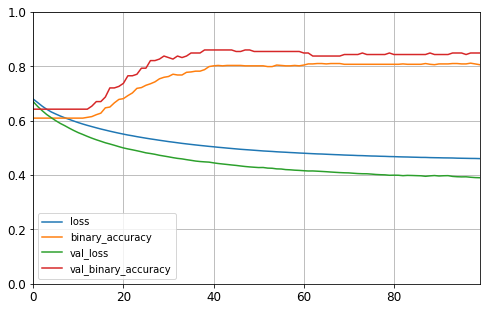

In [27]:
# Plot the learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

<a id="predict"></a>
#### 3.3.4 Predict on the Test data and submit to Kaggle

In [28]:
# calculate predictions, this model scores 0.76555 on Kaggle

submission = pd.read_csv("../input/titanic/gender_submission.csv", index_col='PassengerId')
submission['Survived'] = model1.predict(X_test)
submission['Survived'] = submission['Survived'].apply(lambda x: round(x,0)).astype('int')
submission.to_csv('Titanic_model1.csv')

<a id="functional-model"></a>
### 3.4. Keras Model using Functional API - 0.77511 score

Although it is possible to use Keras Sequential API, for next model as the layers are added one after another, for the sake of this exercise I'll create the model using Functional API.  
The Keras functional API is the way to go for defining complex models, such as multi-output models, directed acyclic graphs, or models with shared layers.  
Comparing with previuos model:
  * I'm using Elu as activation function - ELU function looks a lot like the ReLU function but it has a nonzero gradient for z < 0
  * I'm using Dropout regularization, which is the most popular technique, however L1, L2 and Max-Norm can be used as well.


In [29]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(36, activation="elu")(input_)
drop1 = keras.layers.Dropout(rate=0.2)(hidden1)
hidden2 = keras.layers.Dense(18, activation="elu")(drop1)
drop2 = keras.layers.Dropout(rate=0.2)(hidden2)
hidden3 = keras.layers.Dense(8, activation="elu")(drop2)
output = keras.layers.Dense(1, activation="sigmoid")(hidden3)
model2 = keras.models.Model(inputs=[input_], outputs=[output])

In [30]:
model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 36)                612       
_________________________________________________________________
dropout (Dropout)            (None, 36)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 18)                666       
_________________________________________________________________
dropout_1 (Dropout)          (None, 18)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 152       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9     

In [31]:
# Compile the model
model2.compile(optimizer = 'nadam', 
               loss = 'binary_crossentropy', 
               metrics = ['accuracy'])

The fit() method accepts a callbacks argument that lets you specify a list of objects that Keras will call at the start and end of training, at the start and end of each epoch, and even before and after processing each batch.  
tf.keras.callbacks.EarlyStopping is usefull when you want to stop training when a monitored quantity has stopped improving. The number of epochs can be set to a large value since training will stop automatically when there is no more progress. 

In [32]:
# configure EarlyStopping and ask to restore the best weights
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [33]:
history2 = model2.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping_cb])

Train on 712 samples, validate on 179 samples
Epoch 1/100
712/712 [==============================] - 1s 2ms/sample - loss: 0.7387 - accuracy: 0.5449 - val_loss: 0.5882 - val_accuracy: 0.7207
Epoch 2/100
712/712 [==============================] - 0s 91us/sample - loss: 0.5875 - accuracy: 0.7149 - val_loss: 0.4963 - val_accuracy: 0.7877
Epoch 3/100
712/712 [==============================] - 0s 92us/sample - loss: 0.5222 - accuracy: 0.7823 - val_loss: 0.4407 - val_accuracy: 0.8101
Epoch 4/100
712/712 [==============================] - 0s 95us/sample - loss: 0.4985 - accuracy: 0.7809 - val_loss: 0.4055 - val_accuracy: 0.8268
Epoch 5/100
712/712 [==============================] - 0s 90us/sample - loss: 0.4736 - accuracy: 0.7921 - val_loss: 0.3846 - val_accuracy: 0.8547
Epoch 6/100
712/712 [==============================] - 0s 91us/sample - loss: 0.4745 - accuracy: 0.7893 - val_loss: 0.3743 - val_accuracy: 0.8547
Epoch 7/100
712/712 [==============================] - 0s 92us/sample - loss: 0

In [34]:
val_acc = np.mean(history2.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_acc', val_acc*100))


val_acc: 86.41%


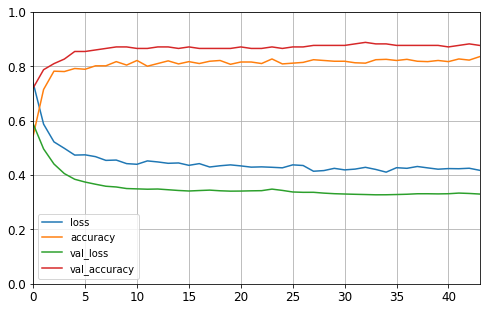

In [35]:
# Plot the learning curves
pd.DataFrame(history2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [36]:
submission2 = pd.read_csv("../input/titanic/gender_submission.csv", index_col='PassengerId')
submission2['Survived'] = model2.predict(X_test)
submission2['Survived'] = submission['Survived'].apply(lambda x: round(x,0)).astype('int')
submission2.to_csv('Titanic_model2.csv')

<a id="hyperparameter"></a>
### 3.5. Hyperparameter Tuning

Create the model, in such way to be configurable.

In [37]:
def build_model(input_shape=[16], n_hidden=1, n_neurons=30, activation = 'relu', optimizer = 'SGD'):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    i = 1
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons/i, activation=activation))
        if n_neurons > 20:
            model.add(keras.layers.Dropout(rate=0.2))
            i = i + 2
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])
    return model

In Keras there is a wrapper for using the Scikit-Learn API with Keras models, which has 2 classes:
 * KerasClassifier: Implementation of the scikit-learn classifier API for Keras.
 * KerasRegressor: Implementation of the scikit-learn regressor API for Keras.

**KerasClassifier** object is a thin wrapper around the Keras model built using build_model(). The object can be used like a regular Scikit-Learn regressor: we can train, evaluate and make predictions using it.

In [38]:

model3 = keras.wrappers.scikit_learn.KerasClassifier(build_fn=build_model)

In [39]:
history3 = model3.fit(X_train, y_train, epochs=100,
              validation_split=0.2,
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Train on 712 samples, validate on 179 samples
Epoch 1/100
712/712 [==============================] - 1s 724us/sample - loss: 0.7399 - accuracy: 0.5112 - val_loss: 0.7218 - val_accuracy: 0.6648
Epoch 2/100
712/712 [==============================] - 0s 76us/sample - loss: 0.6886 - accuracy: 0.6390 - val_loss: 0.6758 - val_accuracy: 0.6648
Epoch 3/100
712/712 [==============================] - 0s 84us/sample - loss: 0.6611 - accuracy: 0.6517 - val_loss: 0.6414 - val_accuracy: 0.7039
Epoch 4/100
712/712 [==============================] - 0s 93us/sample - loss: 0.6260 - accuracy: 0.6994 - val_loss: 0.6151 - val_accuracy: 0.7095
Epoch 5/100
712/712 [==============================] - 0s 80us/sample - loss: 0.6211 - accuracy: 0.6938 - val_loss: 0.5929 - val_accuracy: 0.7095
Epoch 6/100
712/712 [==============================] - 0s 77us/sample - loss: 0.6050 - accuracy: 0.6994 - val_loss: 0.5746 - val_accuracy: 0.7039
Epoch 7/100
712/712 [==============================] - 0s 75us/sample - loss:

In [40]:
val_acc = np.mean(history3.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_acc', val_acc*100))


val_acc: 82.82%


**Random search for hyper parameters.**

In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by n_iter.

**Activation functions**:  
* Relu - Applies the rectified linear unit activation function: max(x, 0)
* Selu - Scaled Exponential Linear Unit (SELU):  scale * x if x > 0 and scale * alpha * (exp(x) - 1) if x < 0 
* Elu - Exponential linear unit: x if x > 0 and alpha * (exp(x)-1) if x < 0

![Activation](https://www.researchgate.net/publication/336539704/figure/fig3/AS:814073524535298@1571101661525/Functions-including-exponential-linear-unit-ELU-parametric-rectified-linear-unit.png)

**Optimizers**:
* SGD - stochastic gradient descent, is the "classical" optimization algorithm. In SGD we compute the gradient of the network loss function with respect to each individual weight in the network. Each forward pass through the network results in a certain parameterized loss function, and use the calculated gradients with the learning rate to move the weights in whatever direction its gradient is pointing.
* Adagrad - scales down the gradient vector along the steepest dimensions
* RMSprop - accumulate only the gradients from the most recent iterations (as opposed to all the gradients since the beginning of training)
* Adam - stands for adaptive moment estimation, combines the ideas of momentum optimization and RMSProp

In [41]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [1, 2, 3, 4],
    "n_neurons": [6, 18, 30, 42, 56, 77, 84, 100],
    "activation": ['relu', 'selu', 'elu'],
    "optimizer": ['SGD', 'RMSprop', 'Adam'],
}

rnd_search_cv = RandomizedSearchCV(model3, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100, validation_split=0.2)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] optimizer=SGD, n_neurons=77, n_hidden=4, activation=relu ........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train on 475 samples, validate on 119 samples
Epoch 1/100
475/475 [==============================] - 1s 2ms/sample - loss: 0.7175 - accuracy: 0.4400 - val_loss: 0.7114 - val_accuracy: 0.3613
Epoch 2/100
475/475 [==============================] - 0s 95us/sample - loss: 0.7065 - accuracy: 0.4632 - val_loss: 0.6944 - val_accuracy: 0.5210
Epoch 3/100
475/475 [==============================] - 0s 98us/sample - loss: 0.6966 - accuracy: 0.5453 - val_loss: 0.6807 - val_accuracy: 0.5546
Epoch 4/100
475/475 [==============================] - 0s 94us/sample - loss: 0.6814 - accuracy: 0.5663 - val_loss: 0.6722 - val_accuracy: 0.5714
Epoch 5/100
475/475 [==============================] - 0s 93us/sample - loss: 0.6803 - accuracy: 0.5874 - val_loss: 0.6642 - val_accuracy: 0.6387
Epoch 6/100
475/475 [==============================] - 0s 94us/sample - loss: 0.6722 - accuracy: 0.6063 - val_loss: 0.6563 - val_accuracy: 0.6303
Epoch 7/100
475/475 [==============================] - 0s 96us/sample - loss: 0

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s remaining:    0.0s


Train on 475 samples, validate on 119 samples
Epoch 1/100
475/475 [==============================] - 1s 2ms/sample - loss: 0.6784 - accuracy: 0.6000 - val_loss: 0.6726 - val_accuracy: 0.6555
Epoch 2/100
475/475 [==============================] - 0s 100us/sample - loss: 0.6793 - accuracy: 0.6295 - val_loss: 0.6688 - val_accuracy: 0.6555
Epoch 3/100
475/475 [==============================] - 0s 104us/sample - loss: 0.6743 - accuracy: 0.6463 - val_loss: 0.6647 - val_accuracy: 0.6387
Epoch 4/100
475/475 [==============================] - 0s 104us/sample - loss: 0.6725 - accuracy: 0.6358 - val_loss: 0.6613 - val_accuracy: 0.6387
Epoch 5/100
475/475 [==============================] - 0s 109us/sample - loss: 0.6719 - accuracy: 0.6379 - val_loss: 0.6581 - val_accuracy: 0.6387
Epoch 6/100
475/475 [==============================] - 0s 100us/sample - loss: 0.6643 - accuracy: 0.6442 - val_loss: 0.6548 - val_accuracy: 0.6387
Epoch 7/100
475/475 [==============================] - 0s 100us/sample - l

In [42]:
rnd_search_cv.best_params_

{'optimizer': 'Adam', 'n_neurons': 42, 'n_hidden': 4, 'activation': 'selu'}

I condn't find a better model configuration using Randomized Search, each time I run it I got different results:  
{'optimizer': 'RMSprop', 'n_neurons': 84, 'n_hidden': 3, 'activation': 'selu'}  
{'optimizer': 'Adam', 'n_neurons': 77, 'n_hidden': 4, 'activation': 'elu'}  
{'optimizer': 'RMSprop', 'n_neurons': 30, 'n_hidden': 1, 'activation': 'relu'}  
{'optimizer': 'RMSprop', 'n_neurons': 6, 'n_hidden': 1, 'activation': 'relu'}  
{'optimizer': 'RMSprop', 'n_neurons': 6, 'n_hidden': 4, 'activation': 'selu'}   
{'optimizer': 'SGD', 'n_neurons': 100, 'n_hidden': 4, 'activation': 'elu'}


In [43]:
model4 = build_model(n_hidden=4, n_neurons=77, input_shape=[16], activation = 'elu', optimizer = 'Adam')

print(model4.summary())

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_116 (Dense)            (None, 77)                1309      
_________________________________________________________________
dropout_67 (Dropout)         (None, 77)                0         
_________________________________________________________________
dense_117 (Dense)            (None, 25)                1950      
_________________________________________________________________
dropout_68 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_118 (Dense)            (None, 15)                390       
_________________________________________________________________
dropout_69 (Dropout)         (None, 15)                0         
_________________________________________________________________
dense_119 (Dense)            (None, 11)              

In [44]:
history4 = model4.fit(X_train, y_train, epochs=100,
                     validation_split=0.2, callbacks=[early_stopping_cb])

Train on 712 samples, validate on 179 samples
Epoch 1/100
712/712 [==============================] - 1s 2ms/sample - loss: 0.6923 - accuracy: 0.5899 - val_loss: 0.5268 - val_accuracy: 0.7765
Epoch 2/100
712/712 [==============================] - 0s 108us/sample - loss: 0.5425 - accuracy: 0.7640 - val_loss: 0.4510 - val_accuracy: 0.8101
Epoch 3/100
712/712 [==============================] - 0s 107us/sample - loss: 0.5110 - accuracy: 0.7795 - val_loss: 0.4125 - val_accuracy: 0.8436
Epoch 4/100
712/712 [==============================] - 0s 105us/sample - loss: 0.4960 - accuracy: 0.7837 - val_loss: 0.3835 - val_accuracy: 0.8547
Epoch 5/100
712/712 [==============================] - 0s 104us/sample - loss: 0.4682 - accuracy: 0.7879 - val_loss: 0.3673 - val_accuracy: 0.8715
Epoch 6/100
712/712 [==============================] - 0s 103us/sample - loss: 0.4633 - accuracy: 0.8034 - val_loss: 0.3602 - val_accuracy: 0.8603
Epoch 7/100
712/712 [==============================] - 0s 106us/sample - l

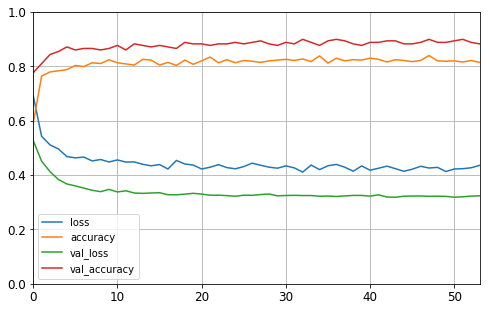

In [45]:
# Plot the learning curves
pd.DataFrame(history4.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [46]:
submission4 = pd.read_csv("../input/titanic/gender_submission.csv", index_col='PassengerId')
submission4['Survived'] = model4.predict(X_test)
submission4['Survived'] = submission['Survived'].apply(lambda x: round(x,0)).astype('int')
submission4.to_csv('Titanic_model4.csv')

Although it was fun to discover Tensorflow and Keras API, using deep learning for this dataser may be overkill, as this dataset is tiny. If you are looking for best performance maybe Ensembling/Stacking with RandomForest and GradientBoosting works best. But I hope you enjoyed the rundown.